# Unsupervised Clustering (K-means, MOG) and PCA on Abalone Dataset

1. Title of Database: Abalone data

2. Sources:

   (a) Original owners of database:
	Marine Resources Division
	Marine Research Laboratories - Taroona
	Department of Primary Industry and Fisheries, Tasmania
	GPO Box 619F, Hobart, Tasmania 7001, Australia
	(contact: Warwick Nash +61 02 277277, wnash@dpi.tas.gov.au)

   (b) Donor of database:
	Sam Waugh (Sam.Waugh@cs.utas.edu.au)
	Department of Computer Science, University of Tasmania
	GPO Box 252C, Hobart, Tasmania 7001, Australia

   (c) Date received: December 1995


3. Past Usage:

   Sam Waugh (1995) "Extending and benchmarking Cascade-Correlation", PhD
   thesis, Computer Science Department, University of Tasmania.

   -- Test set performance (final 1044 examples, first 3133 used for training):
	24.86% Cascade-Correlation (no hidden nodes)
	26.25% Cascade-Correlation (5 hidden nodes)
	21.5%  C4.5
	 0.0%  Linear Discriminate Analysis
	 3.57% k=5 Nearest Neighbour

   David Clark, Zoltan Schreter, Anthony Adams "A Quantitative Comparison of
   Dystal and Backpropagation", submitted to the Australian Conference on
   Neural Networks (ACNN'96). Data set treated as a 3-category classification
   problem (grouping ring classes 1-8, 9 and 10, and 11 on).

   -- Test set performance (3133 training, 1044 testing as above):
	64%    Backprop
	55%    Dystal
   -- Previous work (Waugh, 1995) on same data set:
	61.40% Cascade-Correlation (no hidden nodes)
	65.61% Cascade-Correlation (5 hidden nodes)
	59.2%  C4.5
	32.57% Linear Discriminate Analysis
	62.46% k=5 Nearest Neighbour


4. Background Information:

   Predicting the age of abalone from physical measurements.  The age of
   abalone is determined by cutting the shell through the cone, staining it,
   and counting the number of rings through a microscope -- a boring and
   time-consuming task.  Other measurements, which are easier to obtain, are
   used to predict the age.  Further information, such as weather patterns
   and location (hence food availability) may be required to solve the problem.

   From the original data examples with missing values were removed (the
   majority having the predicted value missing), and the ranges of the
   continuous values have been scaled for use with an ANN (by dividing by 200).

   Data comes from an original (non-machine-learning) study:

	Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and
	Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_
	species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North
	Coast and Islands of Bass Strait", Sea Fisheries Division, Technical
	Report No. 48 (ISSN 1034-3288)


5. Number of Instances: 4177


6. Number of Attributes: 8


7. Attribute information:

   Given is the attribute name, attribute type, the measurement unit and a
   brief description.  The number of rings is the value to predict: either
   as a continuous value or as a classification problem.

    
	- Sex		        nominal			    M, F, and I (infant)
	- Length	        continuous	mm	    Longest shell measurement
	- Diameter	        continuous	mm	    perpendicular to length
	- Height	        continuous	mm	    with meat in shell
	- Whole weight	    continuous	grams	whole abalone
	- Shucked weight	continuous	grams	weight of meat
	- Viscera weight	continuous	grams	gut weight (after bleeding)
	- Shell weight	    continuous	grams	after being dried
	- Rings		        natural number		+1.5 gives the age in years



In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
import itertools
from scipy.stats import multivariate_normal
from sklearn.preprocessing import normalize

%matplotlib inline

In [2]:
'''
References:
1. Ng, Jordan, Weiss. On Spectral Clustering: Analysis and an algorithm. (2001)
2. Zelnik-Manor, Perona. Self-Tuning Spectral Clustering. (2004)

A part of code is taken from hw3.
'''

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('abalone.data', header=None)
dataLabels = ['Sex', 'Length', 'Diam', 'Height','Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell', 'Rings']
data.columns = dataLabels
#dropped point 2051 as it was an outlier
data=data.drop(2051)
data

,Sex,Length,Diam,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


# Our goal with this dataset is to use unsupervised methods to determine the sex of Abalone.

In [4]:
data = pd.DataFrame(data).to_numpy()

#We normalize the final column to be between 0 and 1 in order for k means to notice differences in euclidean distance
# of all variables not just that of the largest
data[:, -1] = normalize(data[:, -1].reshape(-1, 1), axis=0, norm='max').flatten()
labels = data[:, 0]
data = data[:, 1:]
data

array([[0.455, 0.365, 0.095, ..., 0.10099999999999999, 0.15,
        0.5172413793103449],
       [0.35, 0.265, 0.09, ..., 0.0485, 0.07, 0.2413793103448276],
       [0.53, 0.42, 0.135, ..., 0.1415, 0.21, 0.3103448275862069],
       ...,
       [0.6, 0.475, 0.205, ..., 0.2875, 0.308, 0.3103448275862069],
       [0.625, 0.485, 0.15, ..., 0.261, 0.29600000000000004,
        0.3448275862068966],
       [0.71, 0.555, 0.195, ..., 0.3765, 0.495, 0.41379310344827586]],
      dtype=object)

In [5]:
def squaredDistances(dataMat, Kmus):
    N = np.shape(dataMat)[0]
    distMatrix = np.zeros((N, len(Kmus)))
    for row in range(0, N):
        x0, x1, x2, x3, x4, x5, x6, x7 = dataMat[row]
        sq_dists = [(x0-mu[0])**2 + (x1-mu[1])**2 + (x2-mu[2])**2 + (x3-mu[3])**2 + (x4-mu[4])**2
                    + (x5-mu[5])**2 + (x6-mu[6])**2 + (x7-mu[7])**2 for mu in Kmus]
        distMatrix[row] = sq_dists
    return distMatrix

def findRnk(sqDmat):
    Rnk = np.zeros(sqDmat.shape)
    for row in range(0, sqDmat.shape[0]):
        v = sqDmat[row]
        one_hot = [1 if x==min(v) else 0 for x in v]
        Rnk[row] = one_hot
    return Rnk

def recalcMus(dataMat, Rnk):
    N, k = Rnk.shape
    k_mus = np.zeros((k, 8))
    for K in range(0, k):
        l_indices = []
        count = 0
        for row in range(0, N):
            if Rnk[row][K] == 1:
                count += 1
                l_indices.append(dataMat[row].tolist())
        l_indices = np.matrix(l_indices)
        k_mus[K] = np.sum(l_indices, axis = 0) / count
    return k_mus

In [6]:
def run_k_means(data, K, maxiters=1000):
    N, D = data.shape

    Kmus = np.zeros((K, D))

    #initial K-means are random points from the data
    rand_inds = np.random.permutation(N)
    Kmus = data[rand_inds[0:K],:]

    for iter in range(maxiters):
        #calculate the squared distance between each point and the given K means
        #this matrix will be N x K, where N is the number of datapoints and K is the number of means
        
        sqDmat = squaredDistances(data, Kmus)

        
        #given the matrix of squared distances, we now find the closest Kth mean for each data point
        #We calculate the "responsibility" matrix an N x K matrix of binary values, 1 if the
        #data point is closest to the Kth mean and 0 otherwise
        Rnk = findRnk(sqDmat)

        KmusOld = Kmus

        #recalculate mu values based on responsibilities
        Kmus = recalcMus(data, Rnk)

        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld) - Kmus) < 1e-15:
            break


    return Kmus, Rnk

Kmus, Rnk = run_k_means(data, K=3)
Kmus

array([[0.65752024, 0.51825911, 0.18171559, 1.50254504, 0.65858806,
        0.32594383, 0.41875607, 0.41058216],
       [0.41115472, 0.31420933, 0.10490614, 0.37041837, 0.15966382,
        0.08087372, 0.11210381, 0.27954964],
       [0.5705035 , 0.44681469, 0.15221678, 0.92681958, 0.39816224,
        0.20280769, 0.27038706, 0.37301664]])

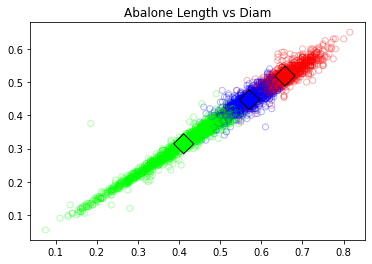

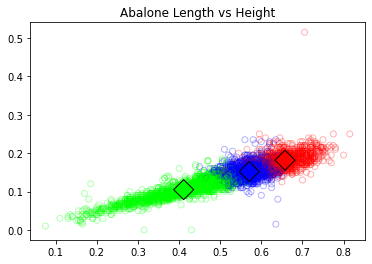

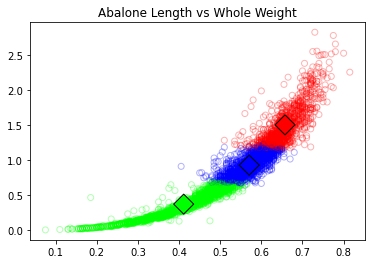

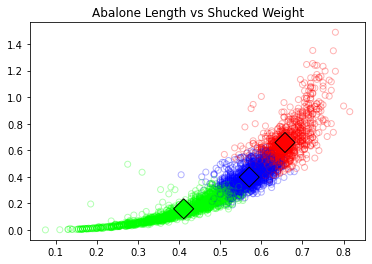

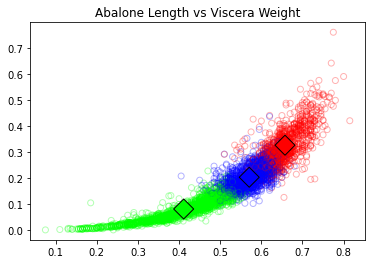

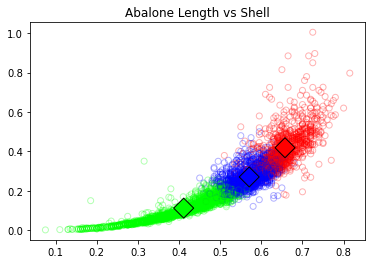

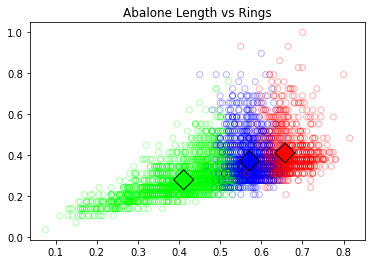

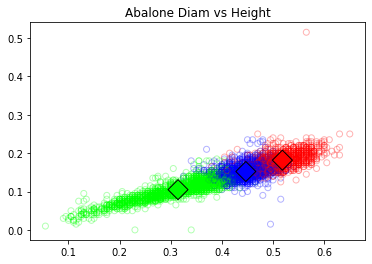

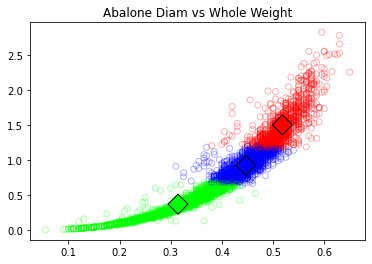

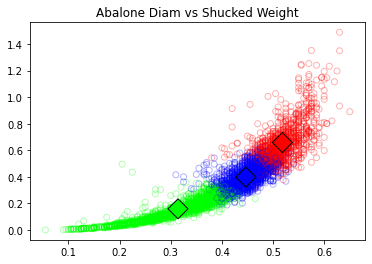

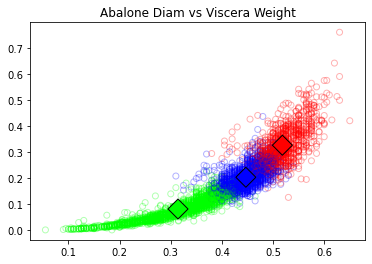

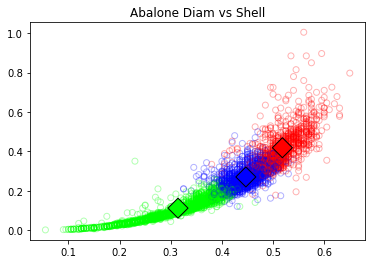

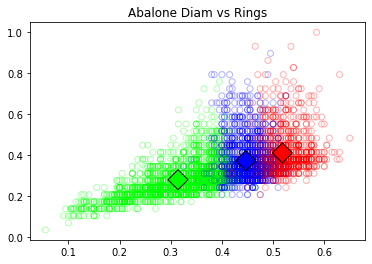

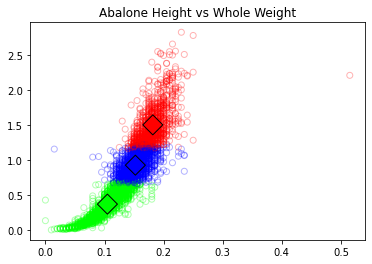

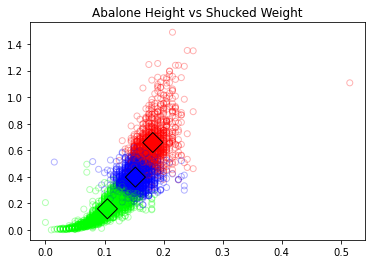

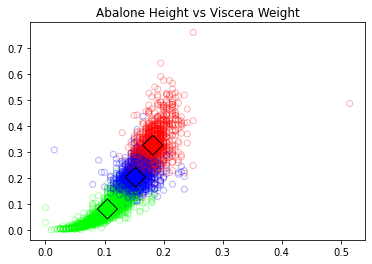

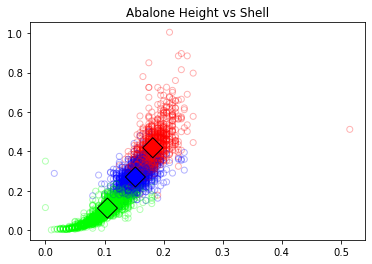

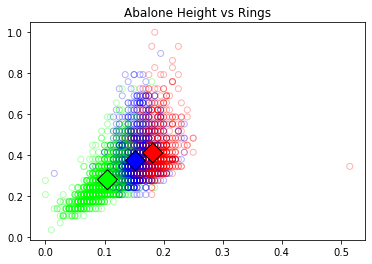

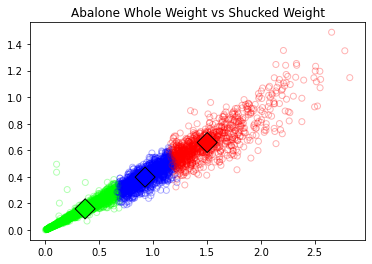

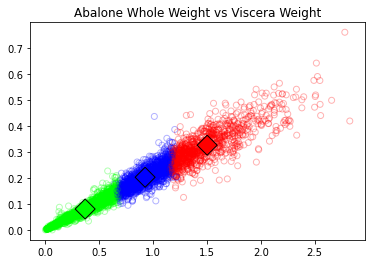

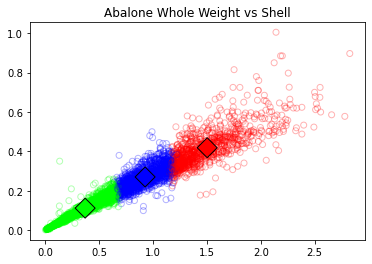

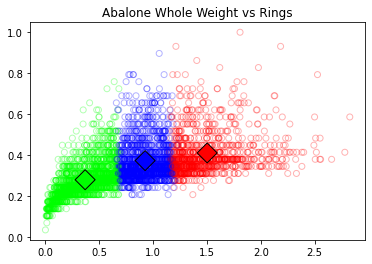

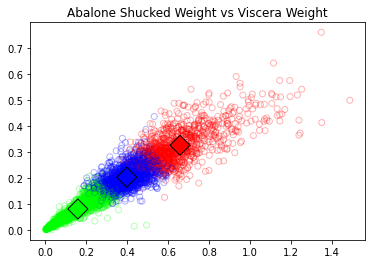

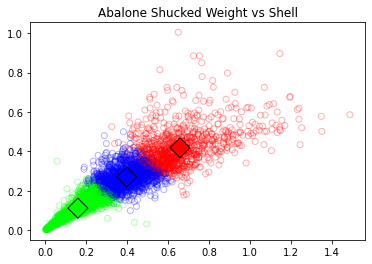

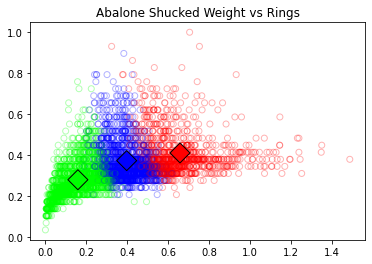

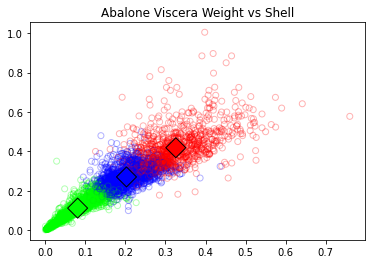

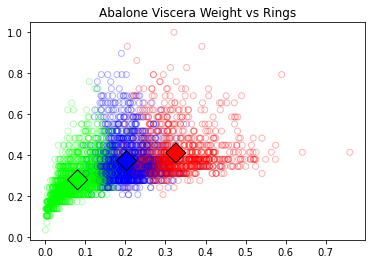

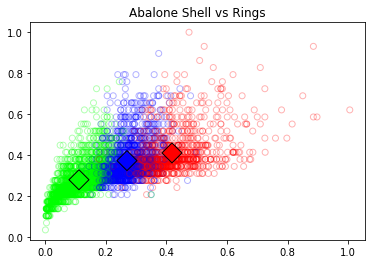

In [7]:
"""We will now aim to visualize the k means in relation to each datapoint
since it is hard for humans to think in 8 dimensions, we will plot 2D scatterplots of the 
data with the associated K means. We will plot all possible 2D combinations of the variable 
of the data with the 2 means for each othese data points. There are obvious limitations
to visualizing in this manner but it is the best we can do."""

x = itertools.combinations([0,1,2,3,4,5,6,7], 2)
possible_2D_combos = []

for subset in x:
    possible_2D_combos.append(subset)
    
dataLabels = tuple(dataLabels[1:])


InitColorMat = np.matrix([[1, 0, 0], 
                          [0, 1, 0],   
                          [0, 0, 1],
                          [0, 0, 0],
                          [1, 1, 0], 
                          [1, 0, 1], 
                          [0, 1, 1]])

KColorMat = InitColorMat[0:Kmus.shape[0]]
colorVec = Rnk.dot(KColorMat)
muColorVec = np.eye(Kmus.shape[0]).dot(KColorMat)

for combo in possible_2D_combos:
    plt.figure()
    plt.title("Abalone " + dataLabels[combo[0]]+ " vs "+ dataLabels[combo[1]])
    plt.scatter(data[:, combo[0]], data[:, combo[1]], edgecolors=colorVec, marker='o', facecolors='none', alpha=0.3)
    plt.scatter(Kmus[:, combo[0]], Kmus[:, combo[1]], edgecolors=[0,0,0], c=muColorVec, marker='D', s=200)
    plt.show()

What we can see from the plots is that the Kmeans for the blue and green datapoints are very close to each other with all possible 2D combinations of the data. The red datapoints K mean is generally further away, based on general knowledge we can assume that the red datapoints are the infants and the blue and green are Male or Female Abalone

- Now we will check the accuracy of our clustering by labeling all datapoints in the blue cluster (or 3rd mean) as infants, and label all green datapoints as female and all red datapoints as male. We will then check the accuracy again switch the red and green for female and male. Note that this is using a little bit of our background knowledge that infants should be smaller and less developed. 

- Alternatively, we could have taken an arbitrary point from each cluster, look at the true Male, Female, and Infant label for this given data point, and assign every datapoint within the same cluster as the same sex. Then calculate the accuracy to which this k-means based prediction method worked. However this method is slightly more error prone to errors in data, outliers, and faulty k-means.

In [8]:
def calc_accuracy(data, r, labels, k_gender_assignment=['M', 'F', 'I'], display=0):
    #the labels are the true labels of the dataset
    # k_gender assignment is the sex we are assigning to each mean in coressponding order
    
    predicted_labels = []
    
    I_correct_count = 0
    M_correct_count = 0
    F_correct_count = 0
    
    I_count = 0
    M_count = 0
    F_count = 0
    
    labels = labels.tolist()
    
    for row in r:
        if (row[0] > row[1]) and (row[0] > row[2]):
            predicted_labels.append(k_gender_assignment[0])
        elif (row[1] > row[0]) and (row[1] > row[2]):
            predicted_labels.append(k_gender_assignment[1])
        elif (row[2] > row[0]) and (row[2] > row[1]):
            predicted_labels.append(k_gender_assignment[2])
    
    for pred, lab in zip(predicted_labels, labels):
        if lab == 'M':
            M_count += 1
            if pred == 'M':
                M_correct_count += 1
            
        if lab == 'F':
            F_count += 1
            if pred == 'F':
                F_correct_count += 1
                
        if lab == 'I':
            I_count += 1
            if pred == 'I':
                I_correct_count += 1
                
    I_accuracy = I_correct_count / I_count
    M_accuracy = M_correct_count / M_count
    F_accuracy = F_correct_count / F_count
    total_accuracy = (I_correct_count+M_correct_count+F_correct_count) / len(labels)
    output = "Total Accuracy: " + str(total_accuracy) + "\nInfant Accuracy: "+str(I_accuracy)+"\nMale Accuracy: "+str(M_accuracy)+"\nFemale Accuracy: "+str(F_accuracy)
    
    if(display):
        print(output)
    
    return total_accuracy, I_accuracy, M_accuracy, F_accuracy

In [9]:
def metaCalcAccu(data, resp, labels):
    perms=[['M', 'F', 'I'],
           ['M', 'I', 'F'],
           ['F', 'M', 'I'],
           ['F', 'I', 'M'],
           ['I', 'M', 'F'],
           ['I', 'F', 'M']]
    bestPerm=['M', 'F', 'I']
    for i in range(6):
        if(calc_accuracy(data, resp, labels, perms[i])>calc_accuracy(data, resp, labels, bestPerm)):
            bestPerm=perms[i]
    
    calc_accuracy(data, resp, labels, bestPerm, 1)

In [10]:
metaCalcAccu(data, Rnk, labels)

Total Accuracy: 0.5296934865900383
Infant Accuracy: 0.8107302533532041
Male Accuracy: 0.42539267015706805
Female Accuracy: 0.36294027565084225


From this, it seems like our clusters did a good job of identifying the infants, but not the minute differences between males and females. While this may be inherent in the data, it is a flaw in creating an intelligent algorithm.

## Lets See if we can get some better results with Mixtures of Gaussians

In [11]:
class MOGModel:
    
    def __init__(self, X, k, max_iters):
        self.X = X
        self.k = k
        self.max_iters = max_iters
        self.dim = self.X.shape[1]
        self.N = self.X.shape[0]
        
        self.mu=data[np.random.permutation(np.size(self.X[0]))[0:k],:]
        self.pi = np.ones(self.k) / self.k
        self.sigma = np.zeros((self.k, self.dim, self.dim))
        for i in range(self.k):
            np.fill_diagonal(self.sigma[i], 1.0) 
            
def expectation(self):
    
        r = np.zeros((self.N, self.k))
        vals=np.zeros((self.k,self.N))
        for c in range(self.k):
            vals[c] = multivariate_normal(mean=self.mu[c], cov=self.sigma[c]).pdf(self.X)
        for i in range(self.N):
            probs = np.zeros(3)
            for c in range(self.k):
                probs[c]=vals[c,i]
            probs = probs/probs.sum()
            r[i]=probs
        return r
    
MOGModel.expectation = expectation

def maximization(self, r):
    
    respons = np.zeros(self.k)
    np.set_printoptions(threshold=6)
    for c in range(self.k):
        for i in range(self.N):
            respons[c]=respons[c]+r[i,c]
    
    for c in range(self.k):
        temp=np.zeros(self.dim)
        for i in range(self.N):
            temp=temp+(r[i,c]*self.X[i])
        self.mu[c]=temp/respons[c]
        self.pi[c]=respons[c]/respons.sum()
        
    for c in range(self.k):
        temp=np.zeros((self.dim,self.dim))
        for i in range(self.N):
            temp2=self.X[i]-self.mu[c]
            temp=temp+(r[i,c]*(np.outer(temp2,temp2)))
        self.sigma[c]=temp/respons[c]
        
MOGModel.maximization = maximization

def run(self):
    r = None
    stats = np.zeros((self.max_iters,4))
    for it in range(self.max_iters):
        r = self.expectation()
        self.maximization(r)
        
        perms=[['M', 'F', 'I'],
                ['M', 'I', 'F'],
                ['F', 'M', 'I'],
                ['F', 'I', 'M'],
                ['I', 'M', 'F'],
                ['I', 'F', 'M']]
        bestPerm=['M', 'F', 'I']
        for i in range(6):
            if(calc_accuracy(data, r, labels, perms[i])>calc_accuracy(data, r, labels, bestPerm)):
                bestPerm=perms[i]
    
        stats[it]=calc_accuracy(data, r, labels, bestPerm, 0)
    
    return r,stats

MOGModel.run = run

In [12]:
MOG = MOGModel(data, 3, 50)
MOGresp,MOGstats=MOG.run()

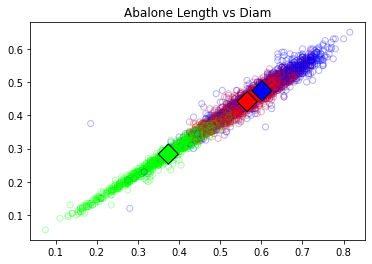

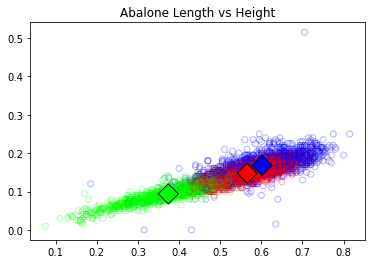

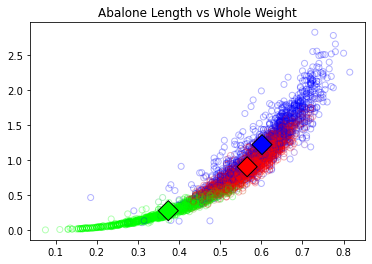

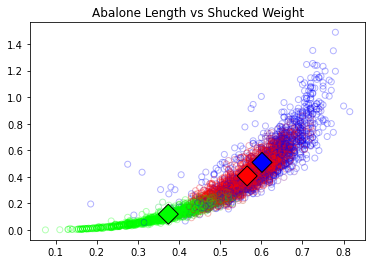

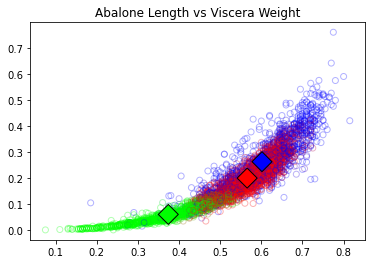

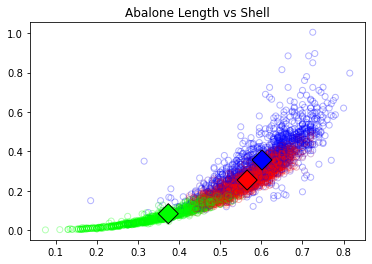

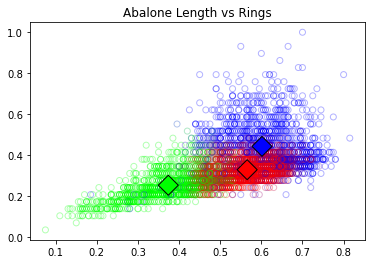

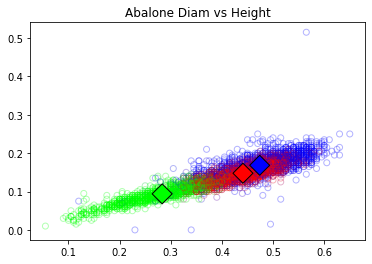

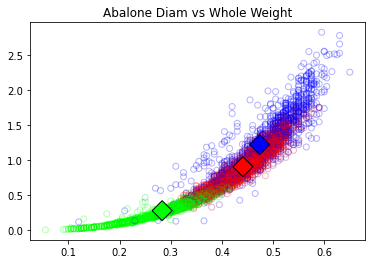

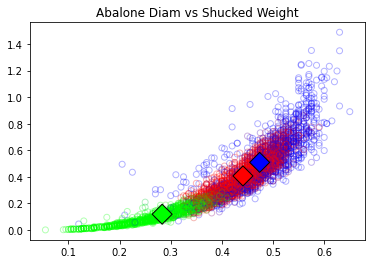

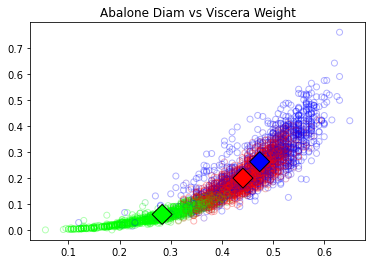

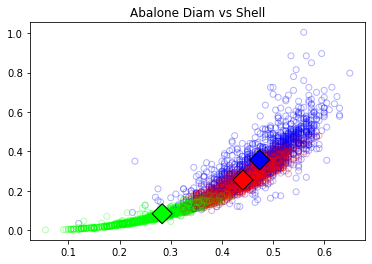

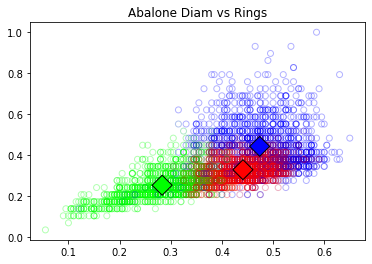

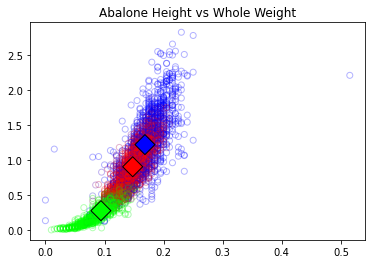

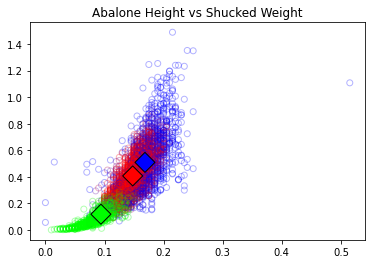

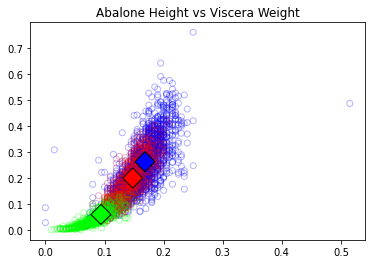

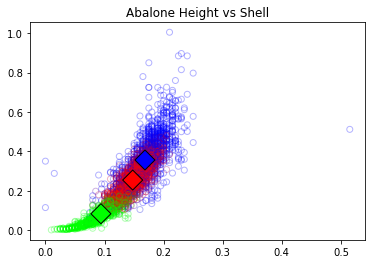

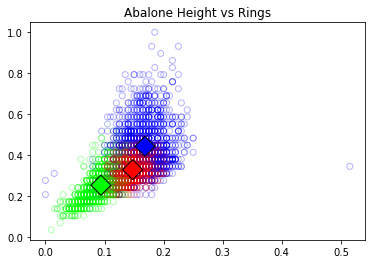

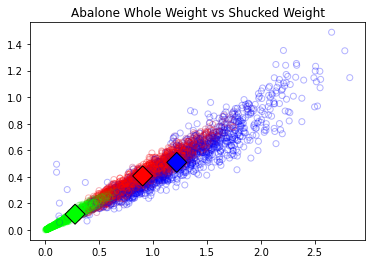

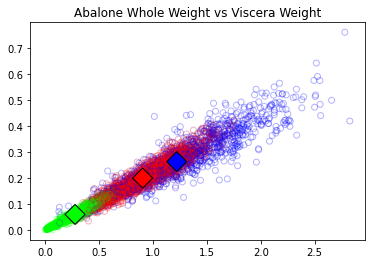

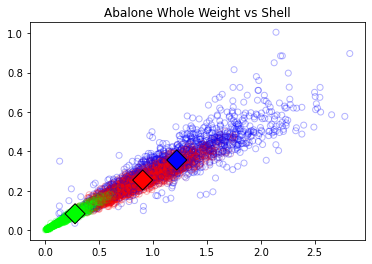

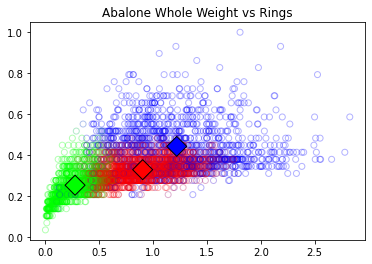

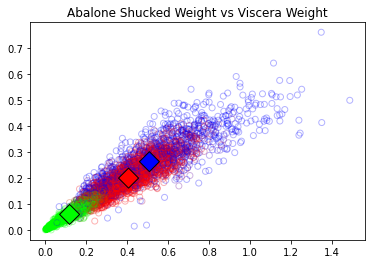

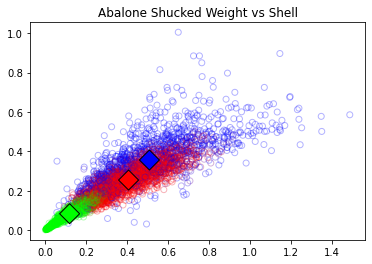

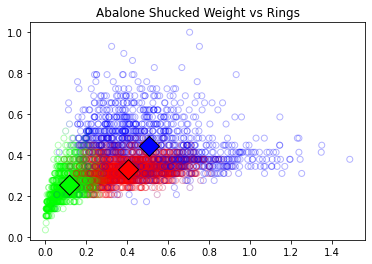

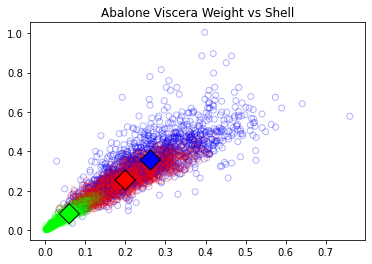

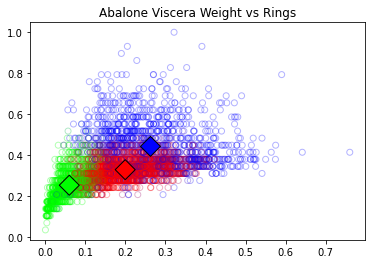

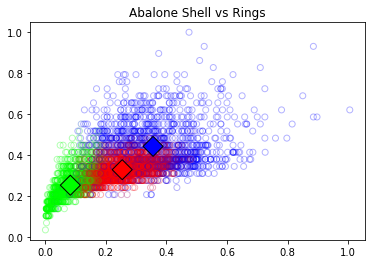

In [13]:
"""We will now aim to visualize the MOG in relation to each datapoint"""

x = itertools.combinations([0,1,2,3,4,5,6,7], 2)
possible_2D_combos = []

for subset in x:
    possible_2D_combos.append(subset)

InitColorMat = np.matrix([[1, 0, 0], 
                          [0, 1, 0],   
                          [0, 0, 1],
                          [0, 0, 0],
                          [1, 1, 0], 
                          [1, 0, 1], 
                          [0, 1, 1]])

KColorMat = InitColorMat[0:MOG.k]
colorVec = MOGresp.dot(KColorMat)
muColorVec = np.eye(MOG.k).dot(KColorMat)

for combo in possible_2D_combos:
    plt.figure()
    plt.title("Abalone " + dataLabels[combo[0]]+ " vs "+ dataLabels[combo[1]])
    plt.scatter(data[:, combo[0]], data[:, combo[1]], edgecolors=colorVec, marker='o', facecolors='none', alpha=0.3)
    temp=np.asarray(MOG.mu)
    plt.scatter(temp[:,combo[0]], temp[:,combo[1]], edgecolors=[0,0,0], c=muColorVec, marker='D', s=200)
    plt.show()
    

Total Accuracy: 0.5014367816091954
Infant Accuracy: 0.6058122205663189
Male Accuracy: 0.48232984293193715
Female Accuracy: 0.4165390505359878


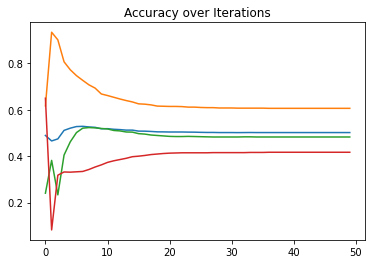

In [14]:
plt.figure()
plt.title("Accuracy over Iterations")
plt.plot(MOGstats)
metaCalcAccu(data, MOGresp, labels)

From these visualizations we can see MOG is definitely able to settling in on 3 clusters, however the Accuracy over time Iterations graph shows that the total Accuracy Actually declined over time as MOG continued to hone in on these clusters that do not exactly match the 3 classifications of our data, perhaps this would be better with supervised learning? (Note, MOG doesnt predict direct outcomes but rather probablilities, this has been simplified for this accuracy algorithm to say MOG believes a point belongs to whichever cluster has the highest responsibility for that point at the end)

## Now on to PCA

In [15]:
def eigsort(V, eigvals):
    # [Vsort,Dsort] = eigsort(V, eigvals)
    #
    # Sorts a matrix eigenvectors and a array of eigenvalues in order 
    # of eigenvalue size, largest eigenvalue first and smallest eigenvalue
    # last.
    #
    # Example usage:
    # di, V = np.linarg.eig(L)
    # Vnew, Dnew = eigsort(V, di)
    #
    # Tim Marks 2002
    
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

In [16]:
#normc(M) normalizes the columns of M to a length of 1.
def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

We will now work in a column based matrix instead of row based (where each column is a sample and not each row), this is just for consistency with the eigenvectors.

In [17]:
data = data.T
data

array([[0.455, 0.35, 0.53, ..., 0.6, 0.625, 0.71],
       [0.365, 0.265, 0.42, ..., 0.475, 0.485, 0.555],
       [0.095, 0.09, 0.135, ..., 0.205, 0.15, 0.195],
       ...,
       [0.10099999999999999, 0.0485, 0.1415, ..., 0.2875, 0.261, 0.3765],
       [0.15, 0.07, 0.21, ..., 0.308, 0.29600000000000004, 0.495],
       [0.5172413793103449, 0.2413793103448276, 0.3103448275862069, ...,
        0.3103448275862069, 0.3448275862068966, 0.41379310344827586]],
      dtype=object)

In [18]:
mean = np.mean(data, axis=1).reshape(8,-1)
mean

array([[0.5240086206896557],
       [0.4078939176245225],
       [0.139279214559386],
       ...,
       [0.1806090756704984],
       [0.2388560823754788],
       [0.34255681067513366]], dtype=object)

In [19]:
dataLabels

('Length',
 'Diam',
 'Height',
 'Whole Weight',
 'Shucked Weight',
 'Viscera Weight',
 'Shell',
 'Rings')

Unfortunately, the mean abalone is hard to view but we can try to imagine it with the labels of the data (i.e. the average age denoted by the number of rings +1.5 is 11.4 years old).
Now we create the sample covariance matrix

In [20]:
Z = data
Z -= mean  #Z is the mean centered data
n = len(Z[0])
covmatrix = (1/n) * np.matmul(Z, Z.T)
covmatrix = np.array(covmatrix, dtype=float)
covmatrix

array([[0.01442117, 0.01175995, 0.00417328, ..., 0.01188616, 0.01500543,
        0.00743206],
       [0.01175995, 0.00984788, 0.00347309, ..., 0.00978648, 0.0125053 ,
        0.00633956],
       [0.00417328, 0.00347309, 0.00151452, ..., 0.00367549, 0.00478389,
        0.00260819],
       ...,
       [0.01188616, 0.00978648, 0.00367549, ..., 0.01201428, 0.01384793,
        0.00613887],
       [0.01500543, 0.0125053 , 0.00478389, ..., 0.01384793, 0.01937473,
        0.00971085],
       [0.00743206, 0.00633956, 0.00260819, ..., 0.00613887, 0.00971085,
        0.01235954]])

In [21]:
eigvals, V = np.linalg.eig(covmatrix) #finding the eigenvalues and eigenvectors (not sorted)
eigvals, V

(array([3.41799709e-01, 1.04127572e-02, 2.96361606e-03, ...,
        1.46397683e-04, 4.31206835e-04, 2.34713504e-04]),
 array([[-0.19232446, -0.09344462,  0.73654939, ...,  0.60312025,
          0.08416069,  0.18315554],
        [-0.15892749, -0.10014122,  0.58141785, ..., -0.78354872,
          0.05919522, -0.03701223],
        [-0.05927396, -0.06269784,  0.110216  , ...,  0.14285747,
         -0.13271857, -0.96948745],
        ...,
        [-0.18119623,  0.03040955, -0.0062462 , ..., -0.03639104,
         -0.61523416,  0.09500139],
        [-0.22764814, -0.22569645, -0.11386008, ...,  0.02197838,
         -0.52099471,  0.11573131],
        [-0.10453258, -0.8855682 , -0.10259781, ...,  0.00573466,
         -0.03126609,  0.03488033]]))

In [22]:
V_sort, D_sort = eigsort(V, eigvals) #sorting the eigenvalues and eigenvectors (visually is harder to see)
V_sort, D_sort

(array([[-0.19232446, -0.09344462,  0.73654939, ...,  0.08416069,
          0.18315554,  0.60312025],
        [-0.15892749, -0.10014122,  0.58141785, ...,  0.05919522,
         -0.03701223, -0.78354872],
        [-0.05927396, -0.06269784,  0.110216  , ..., -0.13271857,
         -0.96948745,  0.14285747],
        ...,
        [-0.18119623,  0.03040955, -0.0062462 , ..., -0.61523416,
          0.09500139, -0.03639104],
        [-0.22764814, -0.22569645, -0.11386008, ..., -0.52099471,
          0.11573131,  0.02197838],
        [-0.10453258, -0.8855682 , -0.10259781, ..., -0.03126609,
          0.03488033,  0.00573466]]),
 array([[3.41799709e-01, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.04127572e-02, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.96361606e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,


In [23]:
print(np.around(V_sort,3))  #printing the eigenvectors and values in a more viewable manner
print(np.around(D_sort, 2)) # most of the eigenvectors are negligible, can't be viewed in 2 decimal points,
                            #and account for close to 0 variance in the data
                            #this would be pretty significant reduction of dimensionality (from 8 down to 2)

[[-0.192 -0.093  0.737 ...  0.084  0.183  0.603]
 [-0.159 -0.1    0.581 ...  0.059 -0.037 -0.784]
 [-0.059 -0.063  0.11  ... -0.133 -0.969  0.143]
 ...
 [-0.181  0.03  -0.006 ... -0.615  0.095 -0.036]
 [-0.228 -0.226 -0.114 ... -0.521  0.116  0.022]
 [-0.105 -0.886 -0.103 ... -0.031  0.035  0.006]]
[[0.34 0.   0.   ... 0.   0.   0.  ]
 [0.   0.01 0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


In [24]:
#now we will convert all datapoints to the space spanned by the eigenvectors in the eigenvectors coordinate system
#using the transpose trick is not efficient here because the number of datapoints is much larger than the number
#of variables the data is represented in
U = normc(V)

#c is the projected 8th datapoint into eigenspace, datapoint reconstructed brings it back to the normal dimensional
#coordinate
c = np.matmul(U, (data[:, 7].reshape(8,-1) - mean))
dataPointReconstructed = np.matmul(U.T, c) + mean

In [25]:
dataPointReconstructed # This is the 8th datapoint projected into the new coordinate system

array([[0.020991379310344227],
       [0.017106082375478393],
       [-0.014279214559379388],
       ...,
       [-0.03110907567048657],
       [0.021143917624533798],
       [0.20916732725589923]], dtype=object)

In [26]:
data[:, 7].reshape(8,-1) # here is the original datapoint, it is the same as the projected
                         # a simple sanity check succeeds

array([[0.020991379310344338],
       [0.017106082375477505],
       [-0.014279214559385994],
       ...,
       [-0.031109075670498393],
       [0.021143917624521197],
       [0.20916732725590081]], dtype=object)

In [27]:
U.shape

(8, 8)

In [28]:
# Now just using the top two eigenvectors (which we saw accounts for the vast majority of variance)
#we will project and recostruct the 8th abalone datapoint and compare it to the original

dataPoint8Reconstructed = np.matmul(U[:, :1], c[:1]) + mean
dataPointReconstructed

array([[0.020991379310344227],
       [0.017106082375478393],
       [-0.014279214559379388],
       ...,
       [-0.03110907567048657],
       [0.021143917624533798],
       [0.20916732725589923]], dtype=object)

The datapoint is the same up to nearly 14 decimal points, which means there is a clear 2 dimensional subspace of the data.